___
# Polygenic Risk Score Accuracy is Dependent on Local Ancestry
___

## Import necessary packages and code

In [296]:
# packages
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from scipy import stats

In [297]:
# code
sys.path.insert(0,"/Users/taylorcavazos/repos/Local_Ancestry_PRS/code/")
from plot_correlations import *
from plot_af_ld import *

## Contents

In [3]:
# To do

## Background

When PRS are built in Europeans they perform poorly in non-Europeans; however, our most powered GWAS are of European populations. Thus moving forward we not only need larger diverse population datsets, but also statistical approaches for generalizing these scores.

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41588-019-0379-x/MediaObjects/41588_2019_379_Fig3_HTML.png)

Performance seems to decrease with decreasing proportion of European ancestry, which led me to the question of whether this accuracy may be depednent on local ancestry proportions within ancestry groups.

## Simulation setup

![](images/methods.jpeg)

____
# Simulation PRS Accuracy

## Pearson's correlation of european derived PRS in African individuals by percent european ancestry at PRS variants

Here we are holding p-value and r2 constant at 0.01 and 0.2

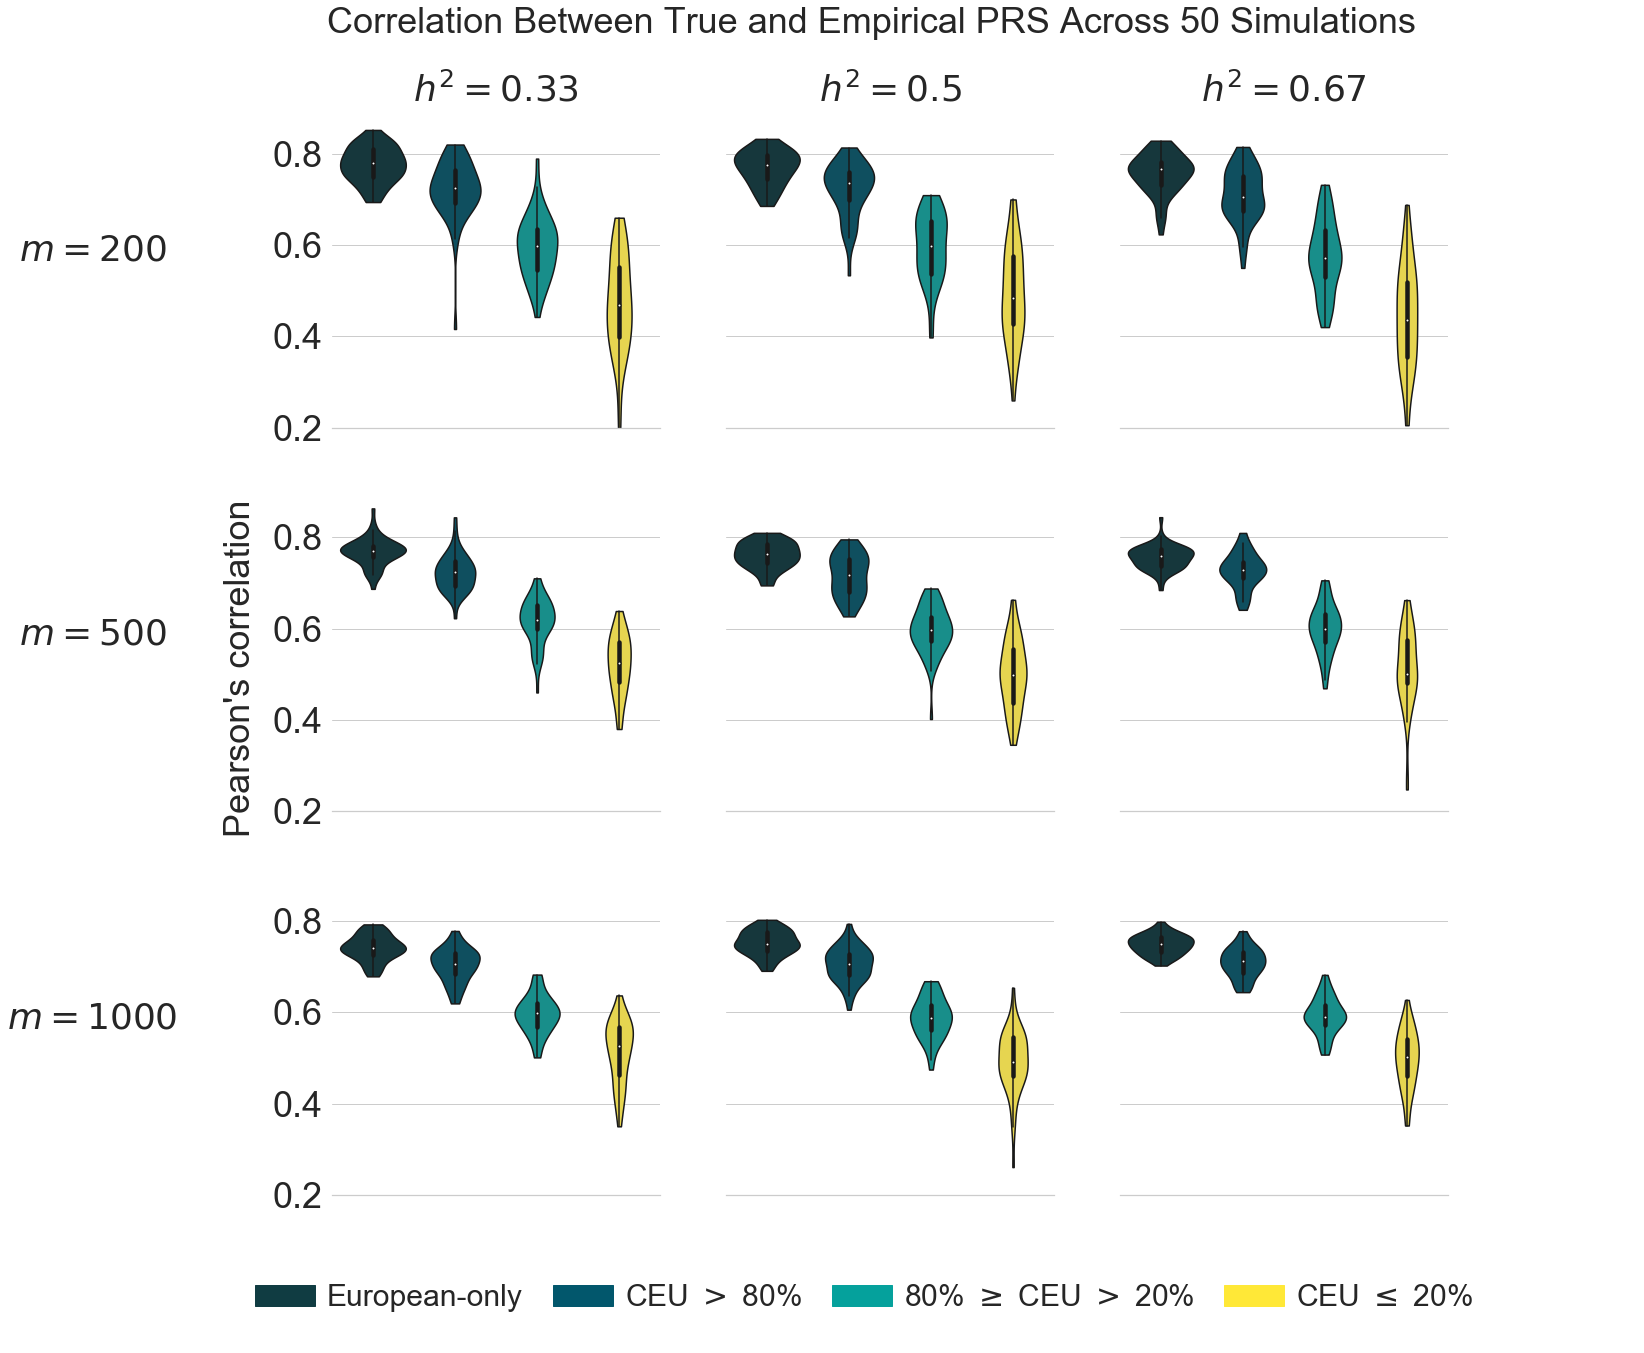

In [4]:
plot_correlation_all_params_eur_weights()
plt.show()

## We can improve PRS accuracy by using local ancestry specific weights 

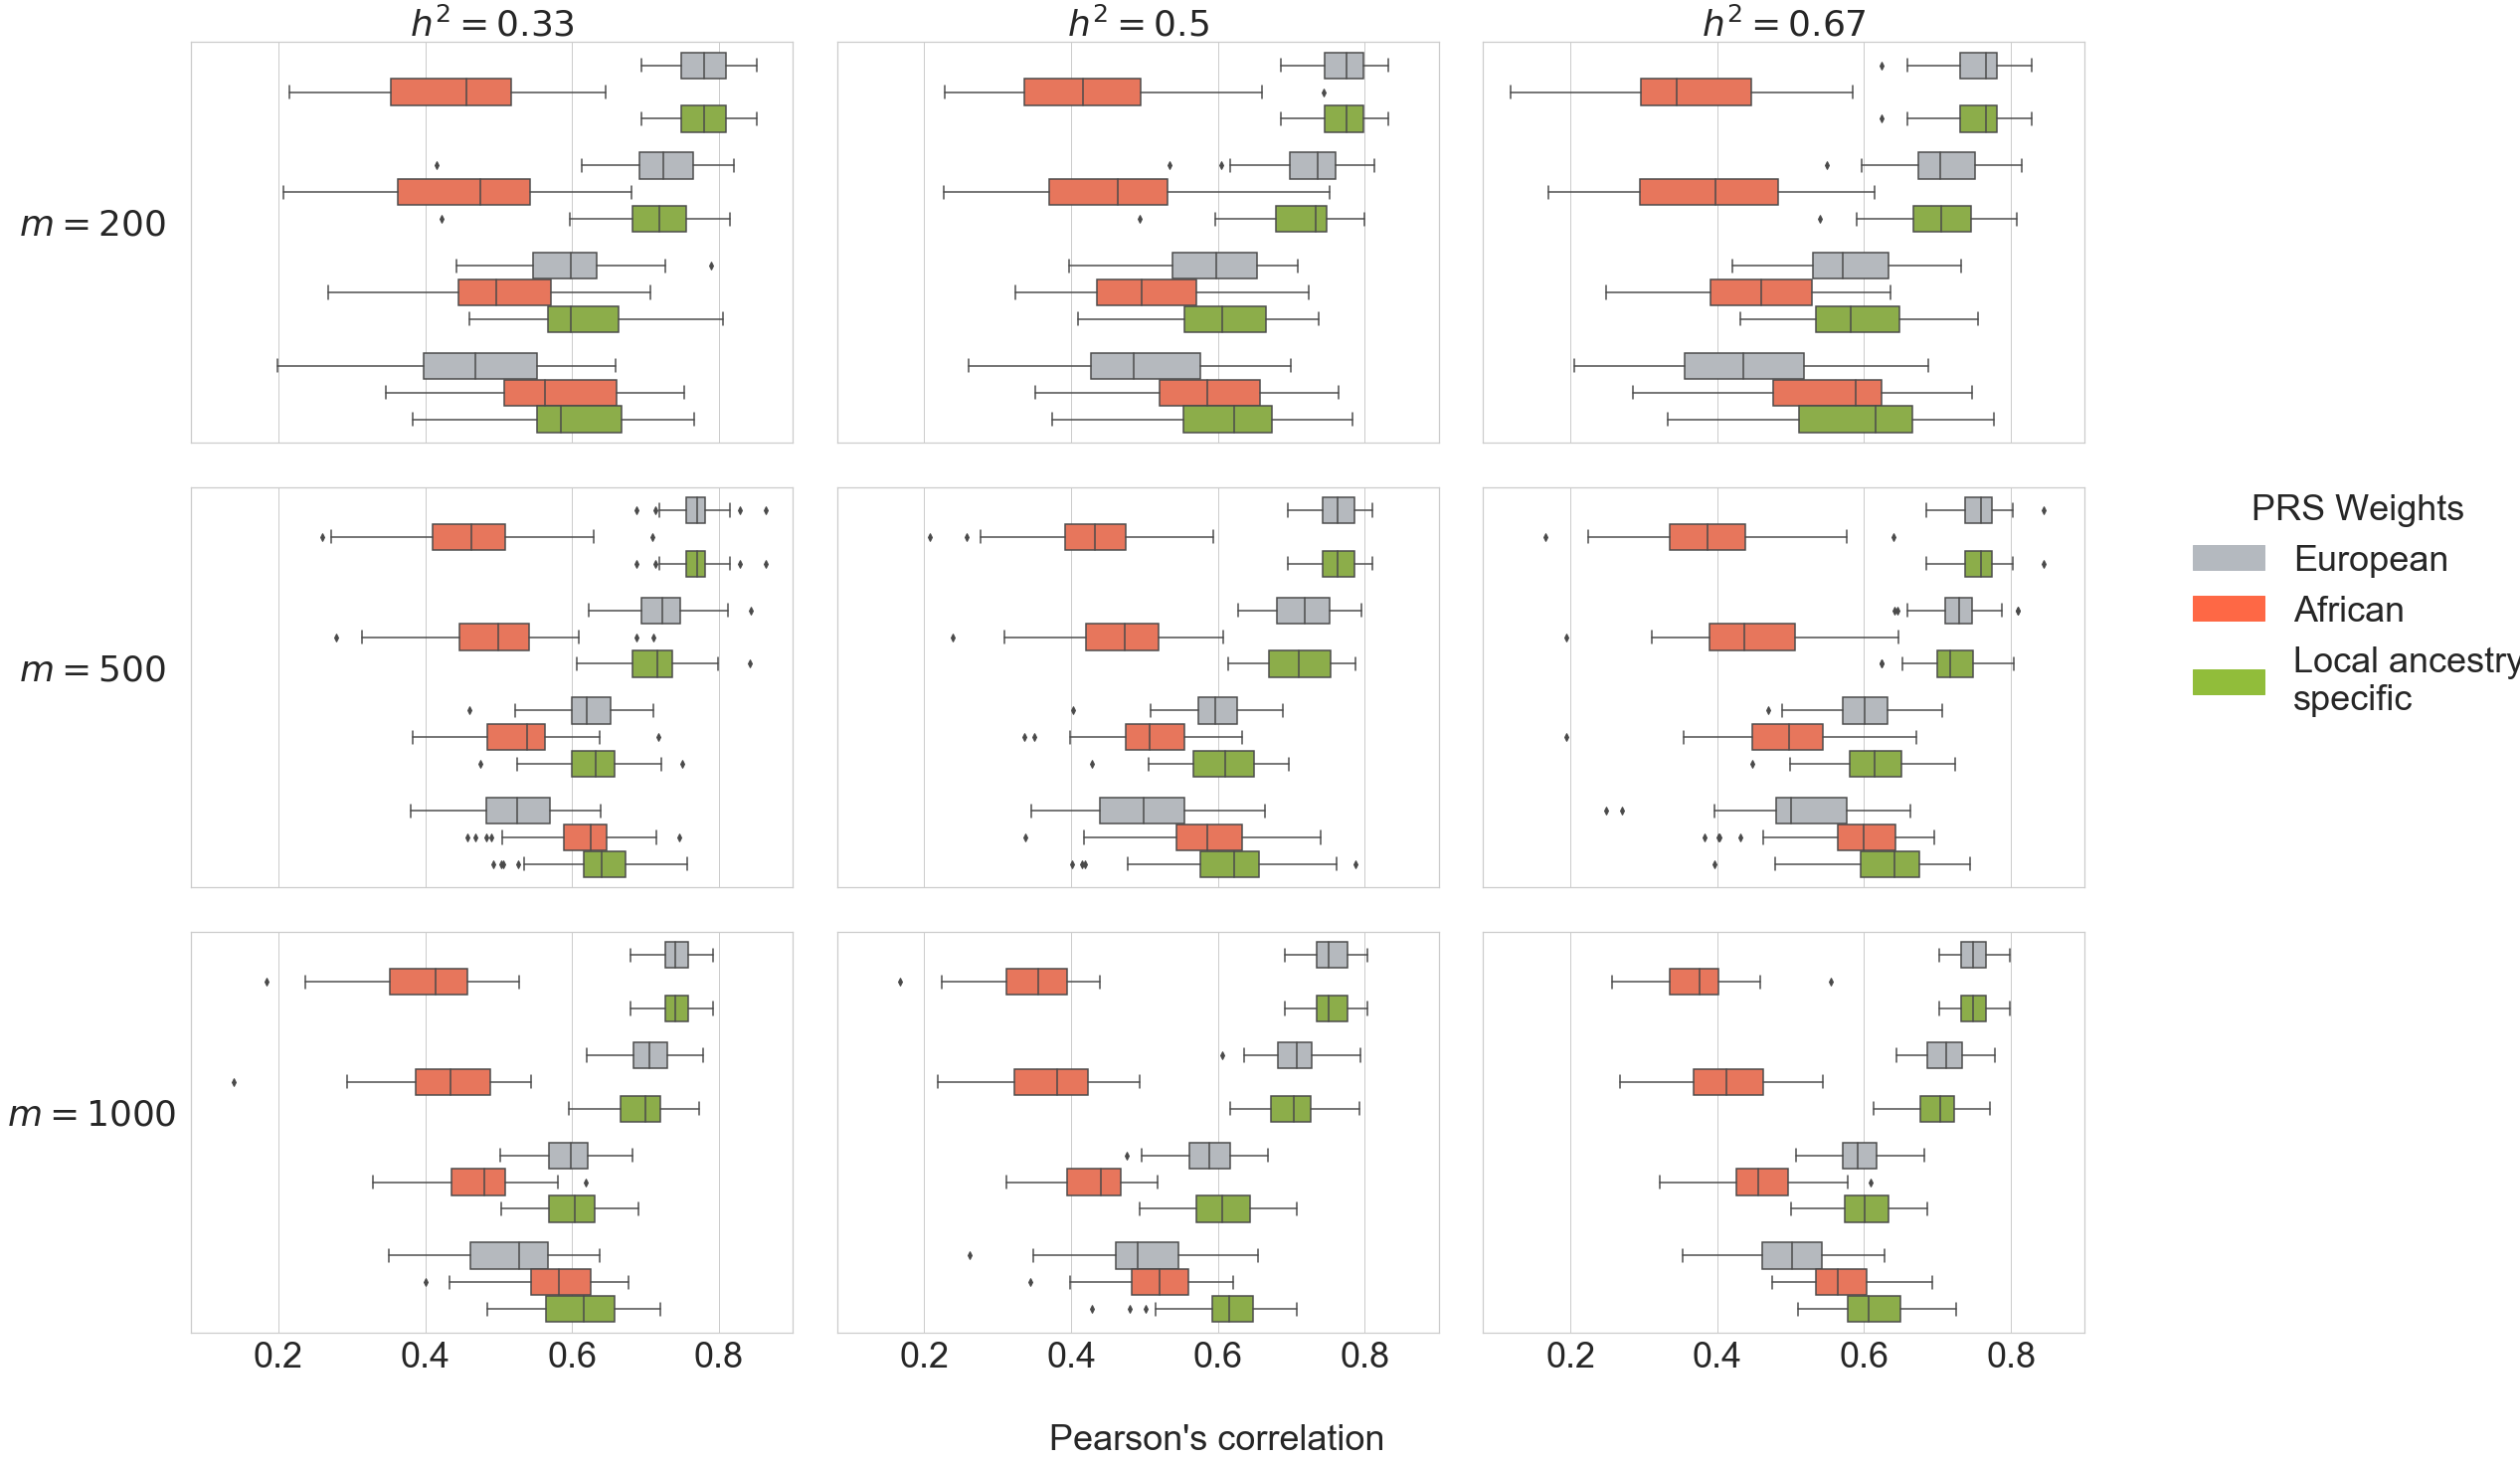

In [5]:
plot_correlation_all_params_all_weights()
plt.show()

#### To move forward with analysis I will limit to parameters $m=1000$ and $h2=0.5$ because although all parameter combinations reflect the same trend, this one is likely to be a closer proximity to true disease biology... hundreds of SNPs have been identified as causal for many common diseases and this isn't including the rare variants that are likely to be discovered (& are causal in my simulation)

In [6]:
data = load_all_weight_summary_data()

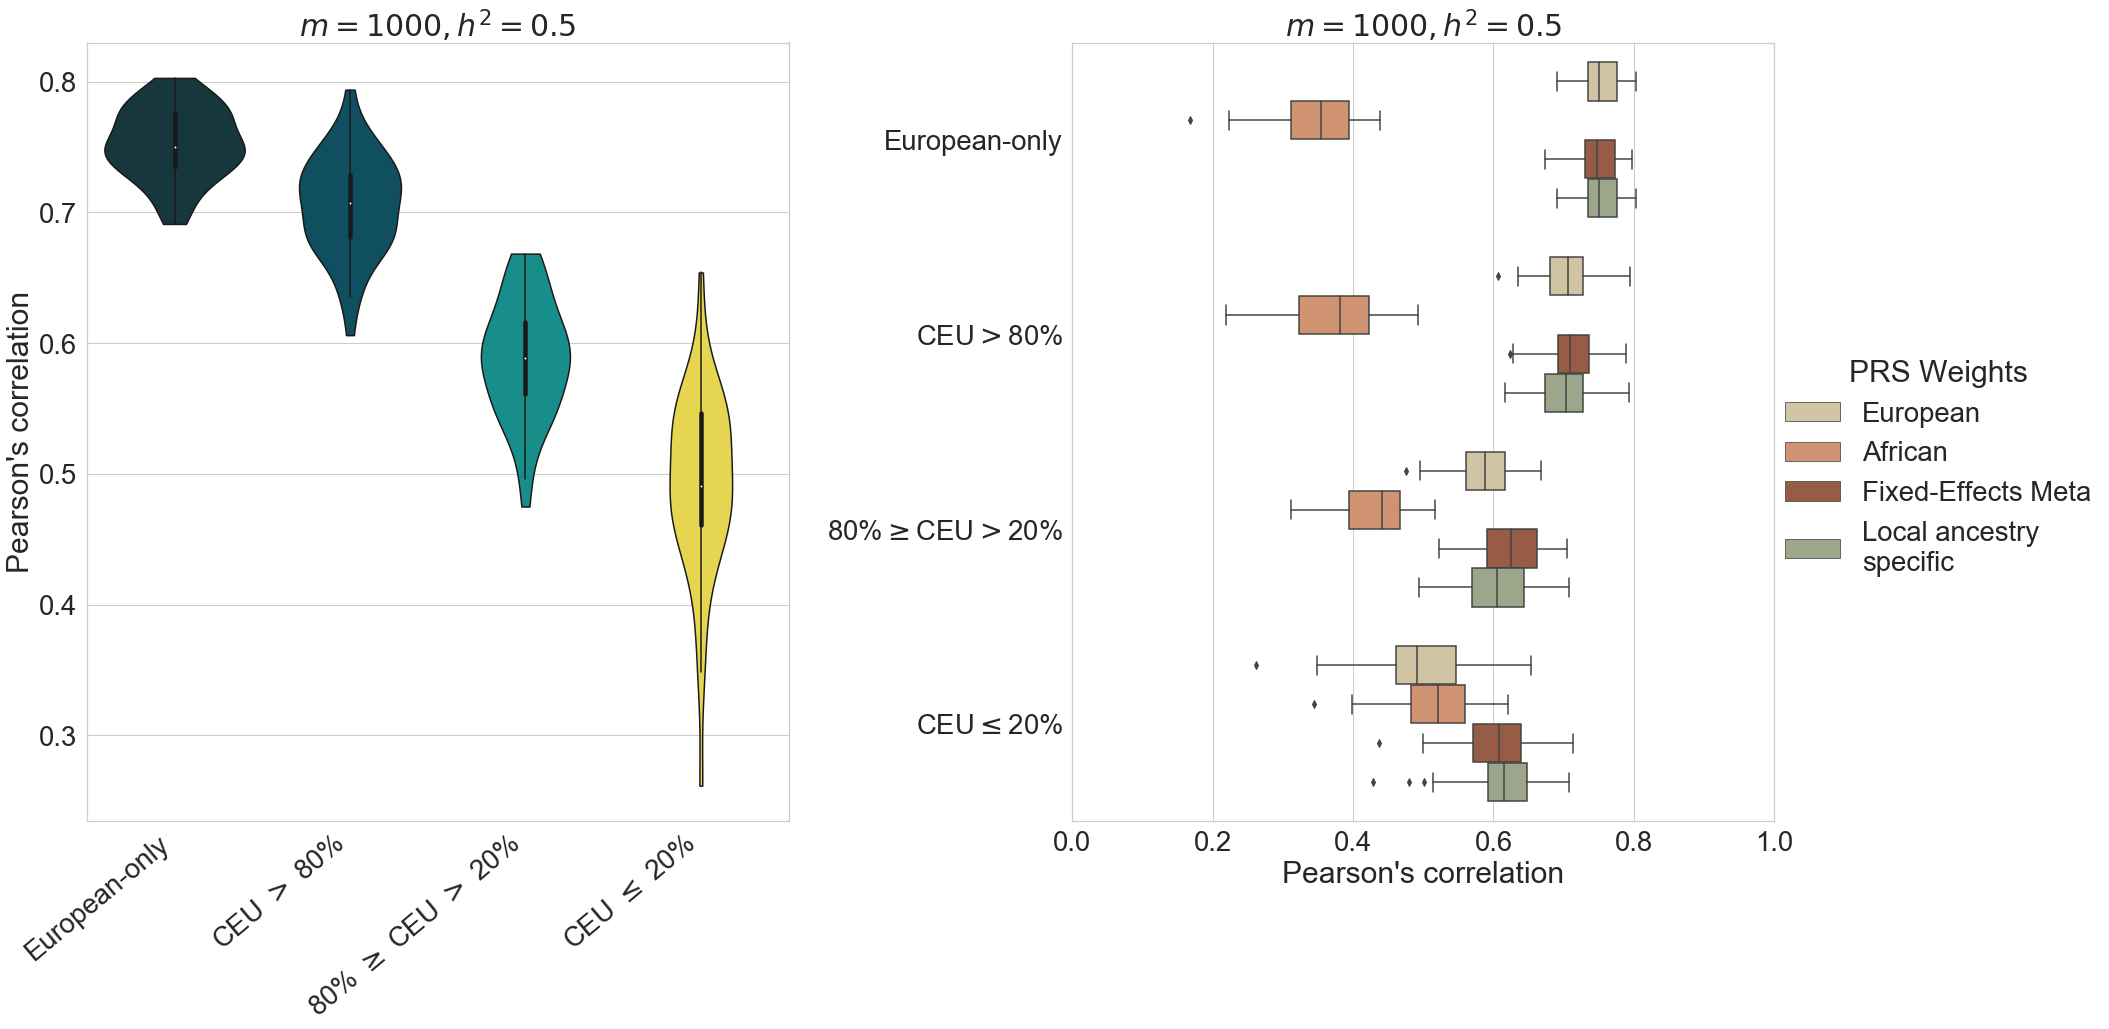

In [7]:
fig,ax = plt.subplots(1,2,figsize=(30,15))
plot_correlation_single_eur_weights(data,ax[0],m=1000,h2=0.5)
plot_correlation_single_all_weights(data,ax[1],m=1000,h2=0.5)
plt.tight_layout()
plt.show()

In [24]:
set(data["weight"])

{'African', 'European', 'Fixed-Effects Meta', 'Local ancestry \nspecific'}

In [25]:
data[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="Local ancestry \nspecific")].mean()

ADMIX_high_eur_corr    7.008118e-01
ADMIX_low_eur_corr     6.137775e-01
ADMIX_mid_eur_corr     6.048903e-01
h2                     5.000000e-01
m                      1.000000e+03
pval                   1.000000e-02
r2                     2.000000e-01
sim                    8.440617e+88
test_ADMIX_corr        5.973814e-01
test_EUR_corr          7.526196e-01
train_corr             8.276641e-01
dtype: float64

In [29]:
data[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="European")].mean()

ADMIX_high_eur_corr    7.058634e-01
ADMIX_low_eur_corr     4.929049e-01
ADMIX_mid_eur_corr     5.883484e-01
h2                     5.000000e-01
m                      1.000000e+03
pval                   1.000000e-02
r2                     2.000000e-01
sim                    7.050950e+88
test_ADMIX_corr        5.761292e-01
test_EUR_corr          7.526196e-01
train_corr             8.276641e-01
dtype: float64

In [30]:
(6.137775e-01-4.929049e-01)/4.929049e-01

0.24522499167689346

In [9]:
(4.929049e-01-7.526196e-01)/7.526196e-01

-0.34508096786211795

In [10]:
1/0.25

4.0

In [11]:
7.058634e-01

0.7058634

In [12]:
data[(data["m"]==1000)&(data["h2"]==0.5)].sort_values(by=["sim","weight"])

,ADMIX_high_eur_corr,ADMIX_low_eur_corr,ADMIX_mid_eur_corr,h2,m,pval,r2,sim,test_ADMIX_corr,test_EUR_corr,train_corr,weight
1,0.379999,0.344252,0.352168,0.5,1000.0,0.01,0.2,1,0.344756,0.290842,0.367175,African
1,0.690164,0.406166,0.539372,0.5,1000.0,0.01,0.2,1,0.533155,0.718246,0.816475,European
1,0.692451,0.563388,0.584552,0.5,1000.0,0.01,0.2,1,0.585686,0.719269,0.816393,Fixed-Effects Meta
1,0.681227,0.606307,0.557931,0.5,1000.0,0.01,0.2,1,0.548222,0.718246,0.816475,Local ancestry \nspecific
10,0.342929,0.508160,0.465243,0.5,1000.0,0.01,0.2,10,0.467355,0.406869,0.456946,African
10,0.606093,0.474253,0.584747,0.5,1000.0,0.01,0.2,10,0.586883,0.743000,0.817801,European
10,0.628073,0.589048,0.620314,0.5,1000.0,0.01,0.2,10,0.624909,0.736526,0.815577,Fixed-Effects Meta
10,0.616857,0.609079,0.618198,0.5,1000.0,0.01,0.2,10,0.625974,0.743000,0.817801,Local ancestry \nspecific
11,0.492887,0.531394,0.451527,0.5,1000.0,0.01,0.2,11,0.446337,0.385661,0.453605,African
11,0.748346,0.532048,0.620106,0.5,1000.0,0.01,0.2,11,0.604199,0.754151,0.833006,European


In [13]:
eur_weight_ceu_only = data.loc[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="European"),"test_EUR_corr"]

afr_weight_ceu_low = data.loc[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="African"),"ADMIX_low_eur_corr"]
eur_weight_ceu_low = data.loc[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="European"),"ADMIX_low_eur_corr"]
LA_weight_ceu_low = data.loc[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="Local ancestry \nspecific"),"ADMIX_low_eur_corr"]
meta_weight_ceu_low = data.loc[(data["m"]==1000)&(data["h2"]==0.5)&(data["weight"]=="Fixed-Effects Meta"),"ADMIX_low_eur_corr"]

In [14]:
stats.ttest_ind(LA_weight_ceu_low,afr_weight_ceu_low)

Ttest_indResult(statistic=8.415428803992958, pvalue=3.2689807444254307e-13)

In [15]:
stats.ttest_ind(LA_weight_ceu_low,meta_weight_ceu_low)

Ttest_indResult(statistic=1.0965035952188085, pvalue=0.27554561585011356)

___

# Impact of decreasing African sample size

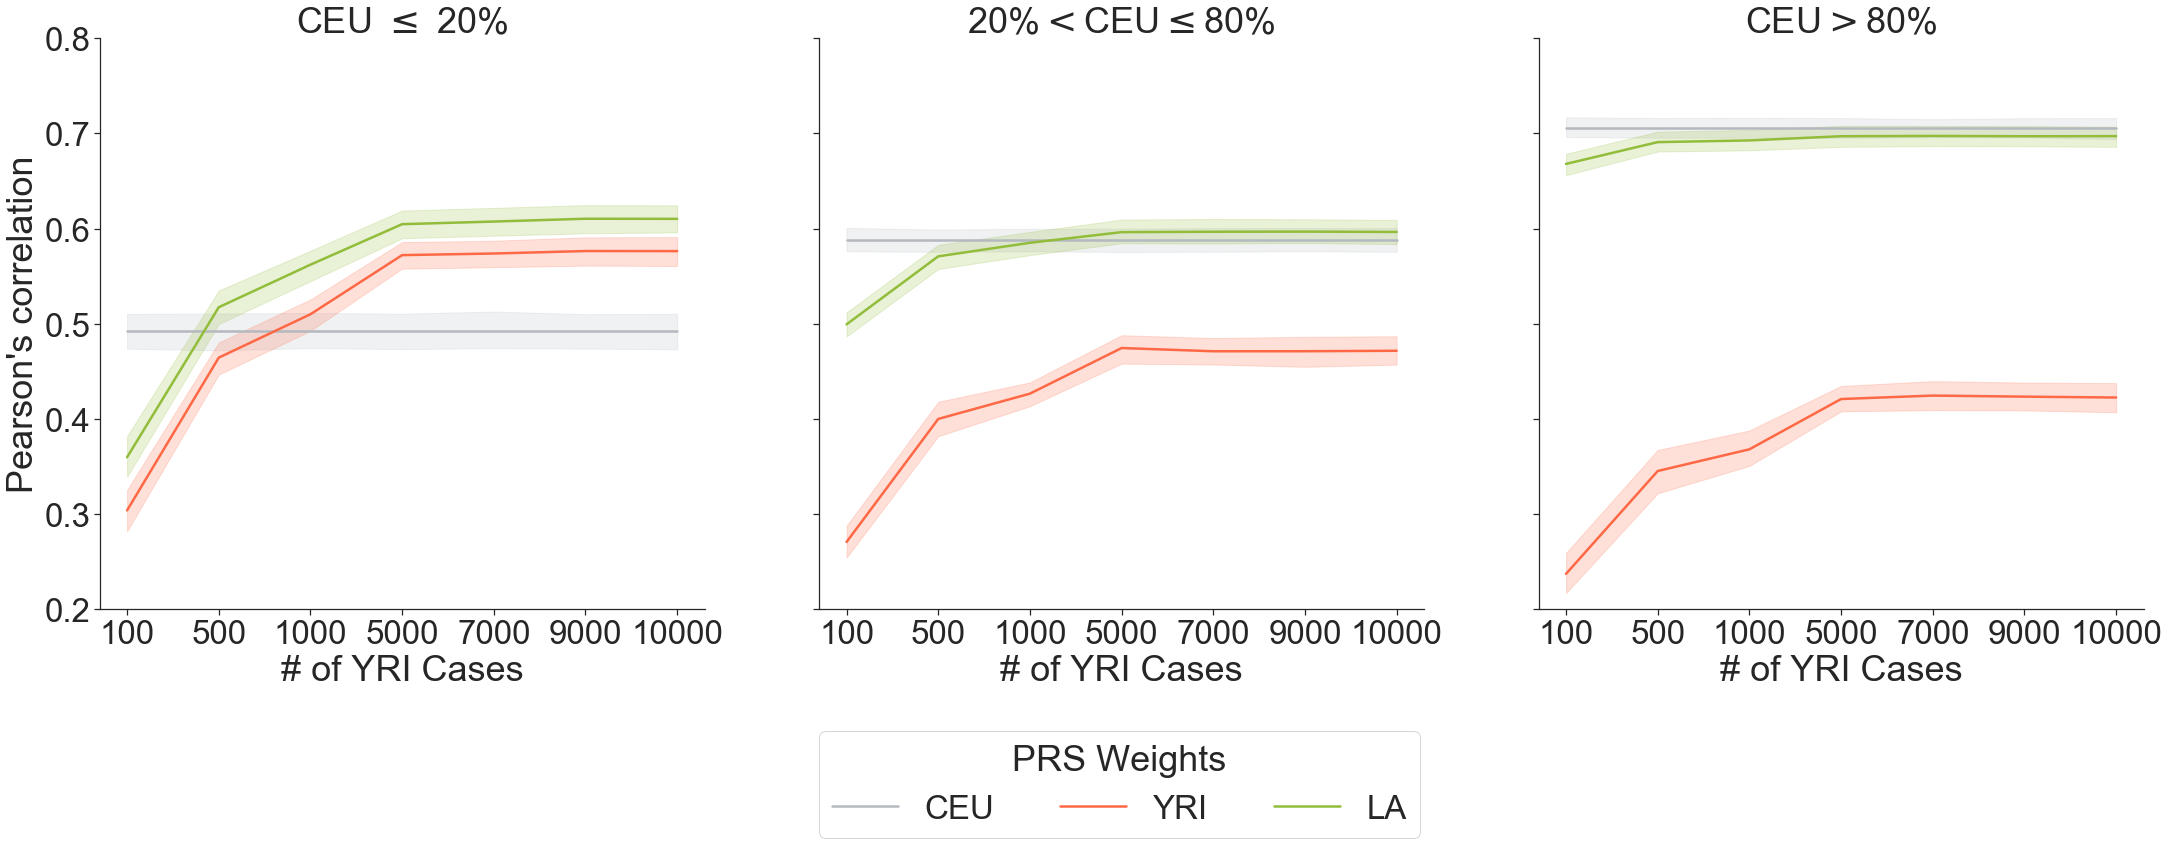

In [16]:
plot_correlation_decreasing_yri_allPops()

# Main Takeaways
#### (1) Local ancestry matters

#### (2) Using ancestry specific weights isn't enough to achieve similar accuracy as PRS in Europeans

___
# Exploration of Simulation PRS -  Why doesn't the European PRS generalize across populations?

## Allele frequency

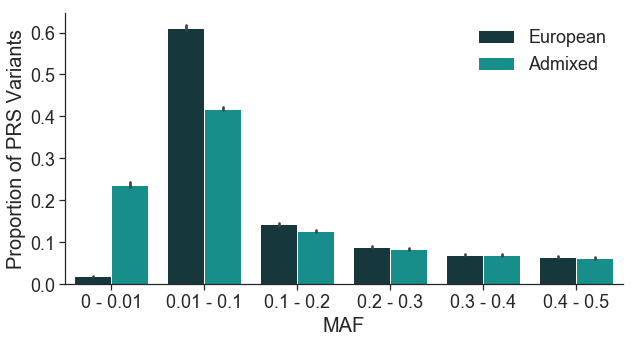

In [17]:
plot_maf_bins()

## Linkage disequilibrium

#### How realistic is LD and does it match expected population differences?
We expect LD to be higher in Europeans and for LD to deteriorate over larger distances.

**Approach:** Calculate distances between all variants, randomly select *1000 pairs* from each distance bin (in kb). Repeat steps across all simulations

In [18]:
mean_mat = pd.DataFrame()
for f in glob.glob("../results/average_ld/*.txt"):
    mean_mat = pd.concat([mean_mat,pd.read_csv(f,sep="\t")])

In [19]:
mean_mat_long = mean_mat.melt(id_vars=["dist_bin"],value_vars=["CEU_r2","YRI_r2"])

In [20]:
sns.set_context("talk")
sns.set_style("ticks")

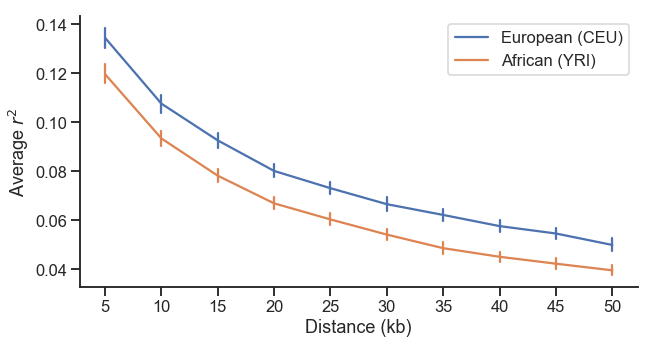

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(x="dist_bin",y="value",data=mean_mat_long,hue="variable",color=["#103c42","#FFDD00"],err_style="bars")

plt.xticks(np.arange(5,55,5))
plt.ylabel("Average $r^2$")
plt.xlabel("Distance (kb)")

plt.legend(title="",labels=["European (CEU)","African (YRI)"])
sns.despine()
plt.show()

#### Relatively similar to expected however LD seems on average lower than in real data and LD decays rapidly

___
# Deep dive into causal variants

(1) If they are present in the summary statistics do they have the effect size? What about the p-values?
* Make plot of one simulation (heatmap of some sort)
* Come up with plot for summarizing all simulations

In [298]:
tree = msprime.load("../data/tree_all.hdf")

In [307]:
df = pd.DataFrame(columns = range(0,4))

In [335]:
toappend = np.transpose(np.array([[0,1],[2,3],["single"]*2,[4,5]]))

In [336]:
to_append = pd.DataFrame(toappend,columns=np.arange(4))

In [341]:
"msp_"+df.append(to_append,ignore_index=True).index.astype(str)

Index(['msp_0', 'msp_1'], dtype='object')

In [301]:
tree.samples(population_id=0)

array([     0,      1,      2, ..., 401997, 401998, 401999], dtype=int32)

In [305]:
tree.samples(population_id=1)

array([402000, 402001, 402002, ..., 807997, 807998, 807999], dtype=int32)

In [306]:
tree.samples(population_id=2)

array([], dtype=int32)

In [302]:
test = [0,1,2,3,4,5]

In [303]:
test[0::2]

[0, 2, 4]

In [304]:
test[1::2]

[1, 3, 5]

In [ ]:
tree_yri = msprime.load("../data/sim2/trees/tree_YRI_GWAS_nofilt.hdf")
tree_ceu = msprime.load("../data/sim2/trees/tree_CEU_GWAS_nofilt.hdf")

causal_vars = np.linspace(0, tree_ceu.num_sites, m, dtype=int,endpoint=False)

yri_sumstats = pd.read_csv("../data/sim2/emp_prs/yri_comm_maf_0.01_sum_stats_m_1000_h2_0.5.txt",index_col=0,sep="\t")
ceu_sumstats = pd.read_csv("../data/sim2/emp_prs/comm_maf_0.01_sum_stats_m_1000_h2_0.5.txt",index_col=0,sep="\t")

___
# Next Steps

### Test different SNP selection approaches
* African, European (done), or Meta selected SNPs

___